In [1]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
import warnings
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM
from tensorflow.keras.utils import to_categorical
from keras.optimizers import Adam, SGD, Adagrad, RMSprop
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, Callback
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
warnings.filterwarnings('ignore', category=DeprecationWarning)
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, confusion_matrix

#### Preprocessing

In [2]:
train, test = [], []
z_train, z_test = [], []
chars =  ["bhA", "ba", "tA", "kaa", "tI"]

def read_ip(path):
    seq = []
    with open(path, 'r') as file:
        # Iterate over the lines in the file
        for line in file:
            data = [float(freq) for freq in line.split()]
            seq.append(data)
    return seq

for ch in chars:
    for f in os.listdir("data/CV_Data/" + str(ch)+"/Train"):
        train.append(read_ip("data/CV_Data/" + str(ch)+"/Train/" + str(f)))
        z_train.append(str(ch))
    for f in os.listdir("data/CV_Data/" + str(ch)+"/Test"):
        test.append(read_ip("data/CV_Data/" + str(ch) + "/Test/" + str(f)))
        z_test.append(str(ch))

In [3]:
train, val, z_train, z_val = train_test_split(train, z_train, test_size=0.2, random_state=42)

In [4]:
label_map = {"bhA":0, "ba":1, "tA":2, "kaa":3, "tI":4}
z_train_onehot = tf.keras.utils.to_categorical([label_map[x] for x in z_train], 5)
z_val_onehot = tf.keras.utils.to_categorical([label_map[x] for x in z_val], 5)
z_test_onehot = tf.keras.utils.to_categorical([label_map[x] for x in z_test], 5)

In [5]:
train_tensor = tf.ragged.constant(train)
test_tensor = tf.ragged.constant(test)
val_tensor = tf.ragged.constant(val)

#### Model

In [6]:
rnn_model_archs = [
    
    [SimpleRNN(64, activation="tanh", batch_input_shape=(None, None, 39), return_sequences=False),
    Dense(5, activation="softmax")],
    
    [SimpleRNN(128, activation="tanh", batch_input_shape=(None, None, 39), return_sequences=False),
    Dense(64, activation="tanh"),
    Dense(5, activation="softmax")],
    
    [SimpleRNN(128, activation="tanh", batch_input_shape=(None, None, 39), return_sequences=True),
    SimpleRNN(96, activation="tanh", return_sequences=False),
    Dense(96, activation="tanh"),
    Dense(5, activation="softmax")],
    
    [SimpleRNN(256, activation="tanh", batch_input_shape=(None, None, 39), return_sequences=True),
    SimpleRNN(128, activation="tanh", return_sequences=False),
    Dense(128, activation="tanh"),
    Dense(5, activation="softmax")],
    
    [SimpleRNN(256, activation="tanh", batch_input_shape=(None, None, 39), return_sequences=True),
    SimpleRNN(128, activation="tanh", return_sequences=True),
    SimpleRNN(128, activation="tanh", return_sequences=False),
    Dense(128, activation="tanh"),
    Dense(5, activation="softmax")],
    
    [SimpleRNN(256, activation="tanh", batch_input_shape=(None, None, 39), return_sequences=True),
    SimpleRNN(256, activation="tanh", return_sequences=True),
    SimpleRNN(128, activation="tanh", return_sequences=False),
    Dense(128, activation="tanh"),
    Dense(5, activation="softmax")]
    
#     [SimpleRNN(256, activation="tanh", batch_input_shape=(None, None, 39), return_sequences=True),
#     SimpleRNN(256, activation="tanh", return_sequences=True),
#     SimpleRNN(128, activation="tanh", return_sequences=True),
#     SimpleRNN(128, activation="tanh", return_sequences=False),
#     Dense(256, activation="tanh"),
#     Dense(128, activation="tanh"),
#     Dense(5, activation="softmax")],
    
#     [SimpleRNN(256, activation="tanh", batch_input_shape=(None, None, 39), return_sequences=True),
#     SimpleRNN(256, activation="tanh", return_sequences=True),
#     SimpleRNN(128, activation="tanh", return_sequences=True),
#     SimpleRNN(128, activation="tanh", return_sequences=False),
#     Dense(256, activation="tanh"),
#     Dense(256, activation="tanh"),
#     Dense(128, activation="tanh"),
#     Dense(5, activation="softmax")],
]

In [9]:
for i in range(len(rnn_model_archs)):
    
    model = Sequential(rnn_model_archs[i])
    loss_fn = tf.keras.losses.CategoricalCrossentropy()
    adam_optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
    model.compile(loss="categorical_crossentropy", optimizer=adam_optimizer, metrics=['accuracy']) 

    # Train the model
    my_callbacks = [EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=10), 
                    TensorBoard(log_dir=f'./logdir/Q2-relu/rnn/arch_{i+1}')]

    model_fit = model.fit(train_tensor, 
                          z_train_onehot, 
                          validation_data=(val_tensor, z_val_onehot), 
                          batch_size=len(train), 
                          epochs=10000, 
                          verbose=0, 
                          validation_split=0.0,
                          callbacks=my_callbacks, 
                          shuffle=False, 
                          validation_batch_size=None)

    hist_metric = 'accuracy'
    print(f'epochs: {len(model_fit.history[hist_metric])}, acc: {model_fit.history[hist_metric][-1]}\n')
    model.save(f'models/Q2-relu/rnn/arch_{i+1}.tf')

    loss, accuracy = model.evaluate(test_tensor,z_test_onehot, verbose=0)
    print(f"Test loss (arch {i+1}):", loss)
    print(f"Test accuracy (arch {i+1}):", accuracy)
    
    loss, accuracy = model.evaluate(val_tensor,z_val_onehot, verbose=0)
    print(f"val loss (arch {i+1}):", loss)
    print(f"val accuracy (arch {i+1}):", accuracy)
    
    loss, accuracy = model.evaluate(train_tensor,z_val_onehot, verbose=0)
    print(f"train loss (arch {i+1}):", loss)
    print(f"train accuracy (arch {i+1}):", accuracy)
    
    print('\n\n\n')

epochs: 45, acc: 0.8679245114326477

INFO:tensorflow:Assets written to: models/Q2-relu/rnn/arch_6.tf\assets
13/13 [==============================] - 1s 49ms/step - loss: 1.1032 - accuracy: 0.5758
Test loss (arch 6): 1.103190541267395
Test accuracy (arch 6): 0.5757575631141663


In [15]:
# more archs - relu

rnn_model_archs_2 = [
    
#     [SimpleRNN(32, activation="relu", batch_input_shape=(None, None, 39), return_sequences=False),
#     Dense(5, activation="softmax")],
    
#     [SimpleRNN(128, activation="tanh", batch_input_shape=(None, None, 39), return_sequences=False),
#     Dense(64, activation="tanh"),
#     Dense(5, activation="softmax")],
    
#     [SimpleRNN(128, activation="sigmoid", batch_input_shape=(None, None, 39), return_sequences=True),
#     SimpleRNN(96, activation="sigmoid", return_sequences=False),
#     Dense(64, activation="sigmoid"),
#     Dense(5, activation="softmax")],
    
#     [SimpleRNN(256, activation="sigmoid", batch_input_shape=(None, None, 39), return_sequences=True),
#     SimpleRNN(128, activation="sigmoid", return_sequences=False),
#     Dense(96, activation="sigmoid"),
#     Dense(5, activation="softmax")],
    
#     [SimpleRNN(256, activation="tanh", batch_input_shape=(None, None, 39), return_sequences=True),
#     SimpleRNN(128, activation="tanh", return_sequences=True),
#     SimpleRNN(96, activation="tanh", return_sequences=False),
#     Dense(64, activation="tanh"),
#     Dense(5, activation="softmax")],
    
    [SimpleRNN(256, activation="tanh", batch_input_shape=(None, None, 39), return_sequences=True),
    SimpleRNN(256, activation="tanh", return_sequences=True),
    SimpleRNN(128, activation="tanh", return_sequences=False),
    Dense(256, activation="tanh"),
    Dense(128, activation="tanh"),
    Dense(128, activation="tanh"),
    Dense(128, activation="tanh"),
    Dense(5, activation="softmax")]
]

In [16]:
for i in range(len(rnn_model_archs_2)):
    
    model = Sequential(rnn_model_archs_2[i])
    loss_fn = tf.keras.losses.CategoricalCrossentropy()
    adam_optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
    model.compile(loss="categorical_crossentropy", optimizer=adam_optimizer, metrics=['accuracy']) 

    # Train the model
    my_callbacks = [EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=10), 
                    TensorBoard(log_dir=f'./logdir/Q2-extra/rnn/arch_{i+1}')]

    model_fit = model.fit(train_tensor, 
                          z_train_onehot, 
                          validation_data=(val_tensor, z_val_onehot), 
                          batch_size=len(train), 
                          epochs=10000, 
                          verbose=0, 
                          validation_split=0.0,
                          callbacks=my_callbacks, 
                          shuffle=False, 
                          validation_batch_size=None)

    hist_metric = 'accuracy'
    print(f'epochs: {len(model_fit.history[hist_metric])}, acc: {model_fit.history[hist_metric][-1]}\n')
    model.save(f'models/Q2-extra/rnn/arch_{i+1}.tf')

    loss, accuracy = model.evaluate(test_tensor,z_test_onehot, verbose=0)
#     print(f"Test loss (arch {i+1}):", loss)
    print(f"Test accuracy (arch {i+1}):", accuracy)
    
    loss, accuracy = model.evaluate(val_tensor,z_val_onehot, verbose=0)
#     print(f"val loss (arch {i+1}):", loss)
    print(f"val accuracy (arch {i+1}):", accuracy)
    
    loss, accuracy = model.evaluate(train_tensor,z_train_onehot, verbose=0)
#     print(f"train loss (arch {i+1}):", loss)
    print(f"train accuracy (arch {i+1}):", accuracy)
    
    print('\n\n\n')

epochs: 29, acc: 0.8852201104164124

INFO:tensorflow:Assets written to: models/Q2-extra/rnn/arch_1.tf\assets
Test accuracy (arch 1): 0.560606062412262
val accuracy (arch 1): 0.5736677050590515
train accuracy (arch 1): 0.8852201104164124






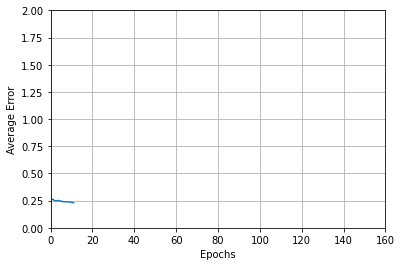

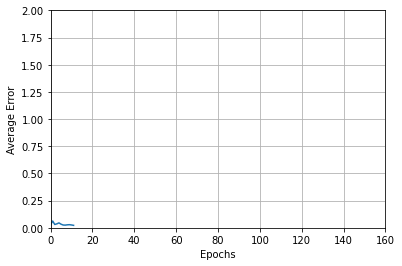

In [39]:
plot_path = 'plotdata/Q2-sig'
for i in range(2):
    df = pd.read_csv(os.path.join(plot_path, f'rnn{i+1}.csv'), usecols=['Step', 'Value'])
    #plt.title(f'arch{i+1}')
    plt.plot(df.Step, df.Value)
    plt.grid()
    plt.xlabel('Epochs')
    plt.ylabel('Average Error')
    plt.xlim([0, 160])
    plt.ylim([0, 2])
    plt.show()

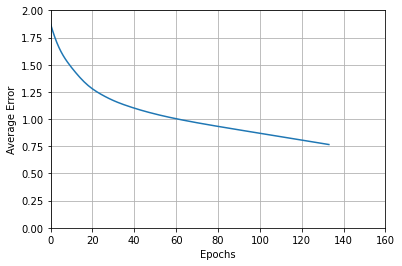

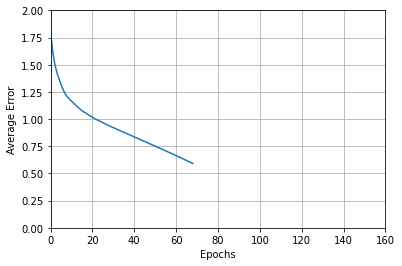

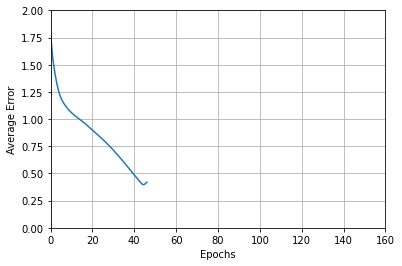

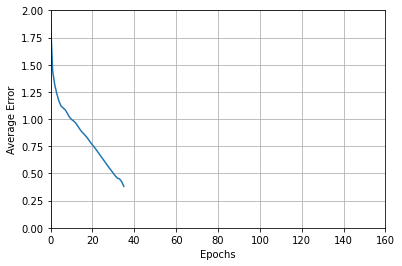

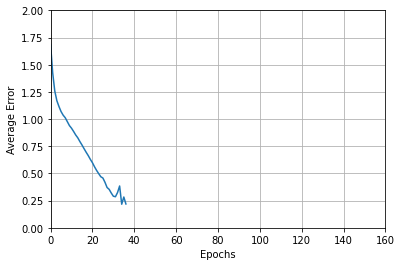

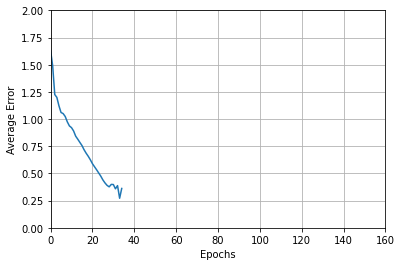

In [18]:
plot_path = 'plotdata/Q2'
for i in range(6):
    df = pd.read_csv(os.path.join(plot_path, f'rnn{i+1}.csv'), usecols=['Step', 'Value'])
    #plt.title(f'arch{i+1}')
    plt.plot(df.Step, df.Value)
    plt.grid()
    plt.xlabel('Epochs')
    plt.ylabel('Average Error')
    plt.xlim([0, 160])
    plt.ylim([0, 2])
    plt.show()

In [20]:
print('RNN')
for i in range(len(rnn_model_archs)):
    model = tf.keras.models.load_model(f'models/Q2/rnn/arch_{i+1}.tf')
    _, acc = model.evaluate(train_tensor, z_train_onehot)   
    print('train acc:', acc) 
    _, acc = model.evaluate(test_tensor,z_test_onehot)   
    print('test acc:', acc)
    _, acc = model.evaluate(val_tensor,z_val_onehot)   
    print('test acc:', acc)
    print('\n\n')

RNN
40/40 [==============================] - 0s 4ms/step - loss: 0.7628 - accuracy: 0.7358
train acc: 0.7358490824699402
13/13 [==============================] - 0s 4ms/step - loss: 1.1668 - accuracy: 0.4697
test acc: 0.469696968793869
10/10 [==============================] - 0s 4ms/step - loss: 1.1874 - accuracy: 0.4859
test acc: 0.4858934283256531



40/40 [==============================] - 0s 5ms/step - loss: 0.5825 - accuracy: 0.8349
train acc: 0.8349056839942932
13/13 [==============================] - 0s 5ms/step - loss: 1.1220 - accuracy: 0.5101
test acc: 0.5101010203361511
10/10 [==============================] - 0s 5ms/step - loss: 1.1888 - accuracy: 0.5016
test acc: 0.5015674233436584



40/40 [==============================] - 1s 10ms/step - loss: 0.3449 - accuracy: 0.8962
train acc: 0.8962264060974121
13/13 [==============================] - 0s 10ms/step - loss: 1.1213 - accuracy: 0.5657
test acc: 0.5656565427780151
10/10 [==============================] - 0s 10ms/step - lo

13/13 [==============================] - 1s 24ms/step


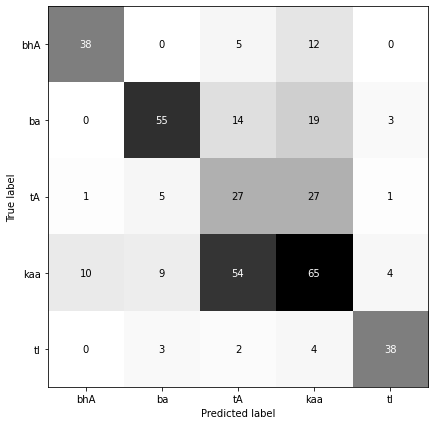

In [21]:
best_arch = 5
model = tf.keras.models.load_model(f'models/Q2/rnn/arch_{best_arch}.tf')
pred = np.argmax(model.predict(test_tensor), axis=1)

fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111)
cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(pred, np.argmax(z_test_onehot, axis=1)), display_labels=chars)
cm_display.plot(ax = ax, cmap='Greys', colorbar=False)
plt.show()

#### LSTM Model

In [8]:
lstm_model_archs = [
    
    [LSTM(64, activation="tanh", batch_input_shape=(None, None, 39), return_sequences=False),
    Dense(5, activation="softmax")],
    
    [LSTM(128, activation="tanh", batch_input_shape=(None, None, 39), return_sequences=False),
    Dense(64, activation="tanh"),
    Dense(5, activation="softmax")],
    
    [LSTM(128, activation="tanh", batch_input_shape=(None, None, 39), return_sequences=True),
    LSTM(96, activation="tanh", return_sequences=False),
    Dense(96, activation="tanh"),
    Dense(5, activation="softmax")],
    
    [LSTM(256, activation="tanh", batch_input_shape=(None, None, 39), return_sequences=True),
    LSTM(128, activation="tanh", return_sequences=False),
    Dense(128, activation="tanh"),
    Dense(5, activation="softmax")],
    
    [LSTM(256, activation="tanh", batch_input_shape=(None, None, 39), return_sequences=True),
    LSTM(128, activation="tanh", return_sequences=True),
    LSTM(128, activation="tanh", return_sequences=False),
    Dense(128, activation="tanh"),
    Dense(5, activation="softmax")],
    
    [LSTM(256, activation="tanh", batch_input_shape=(None, None, 39), return_sequences=True),
    LSTM(256, activation="tanh", return_sequences=True),
    LSTM(128, activation="tanh", return_sequences=False),
    Dense(128, activation="tanh"),
    Dense(5, activation="softmax")]
    
#     [LSTM(256, activation="tanh", batch_input_shape=(None, None, 39), return_sequences=True),
#     LSTM(256, activation="tanh", return_sequences=True),
#     LSTM(128, activation="tanh", return_sequences=True),
#     LSTM(128, activation="tanh", return_sequences=False),
#     Dense(256, activation="tanh"),
#     Dense(128, activation="tanh"),
#     Dense(5, activation="softmax")],
    
#     [LSTM(256, activation="tanh", batch_input_shape=(None, None, 39), return_sequences=True),
#     LSTM(256, activation="tanh", return_sequences=True),
#     LSTM(128, activation="tanh", return_sequences=True),
#     LSTM(128, activation="tanh", return_sequences=False),
#     Dense(256, activation="tanh"),
#     Dense(256, activation="tanh"),
#     Dense(128, activation="tanh"),
#     Dense(5, activation="softmax")],
]

In [9]:
for i in range(len(lstm_model_archs)):
    
    model = Sequential(lstm_model_archs[i])
    loss_fn = tf.keras.losses.CategoricalCrossentropy()
    adam_optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
    model.compile(loss="categorical_crossentropy", optimizer=adam_optimizer, metrics=['accuracy']) 

    # Train the model
    my_callbacks = [EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=10), 
                    TensorBoard(log_dir=f'./logdir/Q2/lstm/arch_{i+1}')]

    model_fit = model.fit(train_tensor, 
                          z_train_onehot, 
                          validation_data=(val_tensor, z_val_onehot), 
                          batch_size=len(train), 
                          epochs=10000, 
                          verbose=0, 
                          validation_split=0.0,
                          callbacks=my_callbacks, 
                          shuffle=False, 
                          validation_batch_size=None)

    hist_metric = 'accuracy'
    print(f'epochs: {len(model_fit.history[hist_metric])}, acc: {model_fit.history[hist_metric][-1]}\n')
    model.save(f'models/Q2/lstm/arch_{i+1}.tf')

    loss, accuracy = model.evaluate(test_tensor,z_test_onehot)
    
    print(f"Test loss (arch {i+1}):", loss)
    print(f"Test accuracy (arch {i+1}):", accuracy)

epochs: 108, acc: 0.9827044010162354



INFO:tensorflow:Assets written to: models/Q2/lstm/arch_1.tf\assets


INFO:tensorflow:Assets written to: models/Q2/lstm/arch_1.tf\assets


13/13 [==============================] - 0s 6ms/step - loss: 0.4233 - accuracy: 0.8485
Test loss (arch 1): 0.4233311116695404
Test accuracy (arch 1): 0.8484848737716675
epochs: 71, acc: 0.9960691928863525



INFO:tensorflow:Assets written to: models/Q2/lstm/arch_2.tf\assets


INFO:tensorflow:Assets written to: models/Q2/lstm/arch_2.tf\assets


13/13 [==============================] - 0s 12ms/step - loss: 0.4051 - accuracy: 0.8561
Test loss (arch 2): 0.40507060289382935
Test accuracy (arch 2): 0.8560606241226196
epochs: 46, acc: 0.9952830076217651



INFO:tensorflow:Assets written to: models/Q2/lstm/arch_3.tf\assets


INFO:tensorflow:Assets written to: models/Q2/lstm/arch_3.tf\assets


13/13 [==============================] - 0s 26ms/step - loss: 0.4076 - accuracy: 0.8813
Test loss (arch 3): 0.4075973927974701
Test accuracy (arch 3): 0.881313145160675
epochs: 38, acc: 0.9952830076217651



INFO:tensorflow:Assets written to: models/Q2/lstm/arch_4.tf\assets


INFO:tensorflow:Assets written to: models/Q2/lstm/arch_4.tf\assets


13/13 [==============================] - 1s 56ms/step - loss: 0.5228 - accuracy: 0.8838
Test loss (arch 4): 0.5228316783905029
Test accuracy (arch 4): 0.8838383555412292
epochs: 35, acc: 0.9944968819618225



INFO:tensorflow:Assets written to: models/Q2/lstm/arch_5.tf\assets


INFO:tensorflow:Assets written to: models/Q2/lstm/arch_5.tf\assets


13/13 [==============================] - 1s 82ms/step - loss: 0.4910 - accuracy: 0.8687
Test loss (arch 5): 0.4910040497779846
Test accuracy (arch 5): 0.868686854839325
epochs: 30, acc: 0.9889937043190002



INFO:tensorflow:Assets written to: models/Q2/lstm/arch_6.tf\assets


INFO:tensorflow:Assets written to: models/Q2/lstm/arch_6.tf\assets


13/13 [==============================] - 2s 135ms/step - loss: 0.4301 - accuracy: 0.8712
Test loss (arch 6): 0.43014127016067505
Test accuracy (arch 6): 0.8712121248245239


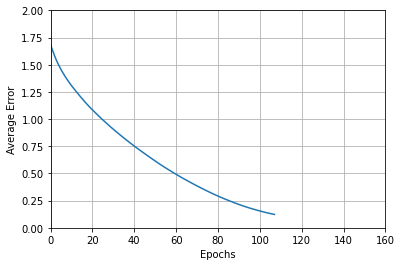

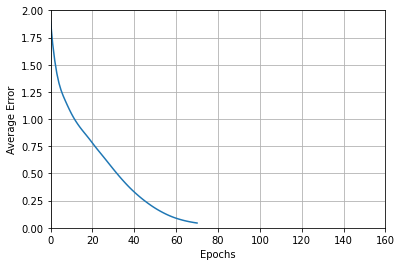

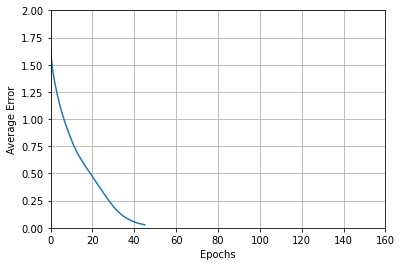

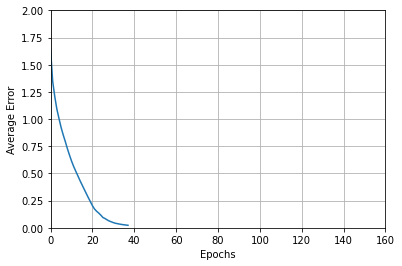

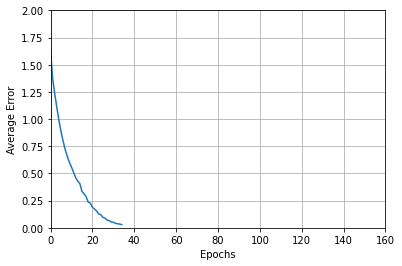

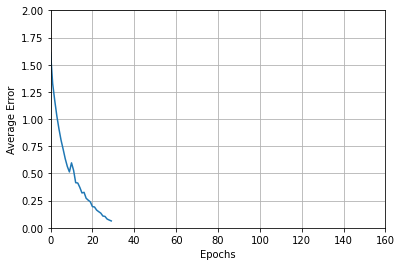

In [22]:
plot_path = 'plotdata/Q2'
for i in range(6):
    df = pd.read_csv(os.path.join(plot_path, f'lstm{i+1}.csv'), usecols=['Step', 'Value'])
    #plt.title(f'arch{i+1}')
    plt.plot(df.Step, df.Value)
    plt.grid()
    plt.xlabel('Epochs')
    plt.ylabel('Average Error')
    plt.xlim([0, 160])
    plt.ylim([0, 2])
    plt.show()

In [23]:
print('LSTM')
for i in range(len(rnn_model_archs)):
    model = tf.keras.models.load_model(f'models/Q2/lstm/arch_{i+1}.tf')
    _, acc = model.evaluate(train_tensor, z_train_onehot)   
    print('train acc:', acc) 
    _, acc = model.evaluate(test_tensor,z_test_onehot)   
    print('test acc:', acc)
    _, acc = model.evaluate(val_tensor,z_val_onehot)   
    print('test acc:', acc)
    print('\n\n')

LSTM
40/40 [==============================] - 1s 8ms/step - loss: 0.1188 - accuracy: 0.9827
train acc: 0.9827044010162354
13/13 [==============================] - 0s 8ms/step - loss: 0.4233 - accuracy: 0.8485
test acc: 0.8484848737716675
10/10 [==============================] - 0s 9ms/step - loss: 0.5303 - accuracy: 0.8213
test acc: 0.8213165998458862



40/40 [==============================] - 1s 15ms/step - loss: 0.0413 - accuracy: 0.9961
train acc: 0.9960691928863525
13/13 [==============================] - 0s 14ms/step - loss: 0.4051 - accuracy: 0.8561
test acc: 0.8560606241226196
10/10 [==============================] - 0s 15ms/step - loss: 0.5744 - accuracy: 0.7837
test acc: 0.7836990356445312



40/40 [==============================] - 2s 29ms/step - loss: 0.0245 - accuracy: 0.9953
train acc: 0.9952830076217651
13/13 [==============================] - 0s 30ms/step - loss: 0.4076 - accuracy: 0.8813
test acc: 0.881313145160675
10/10 [==============================] - 0s 29ms/step 

13/13 [==============================] - 1s 28ms/step


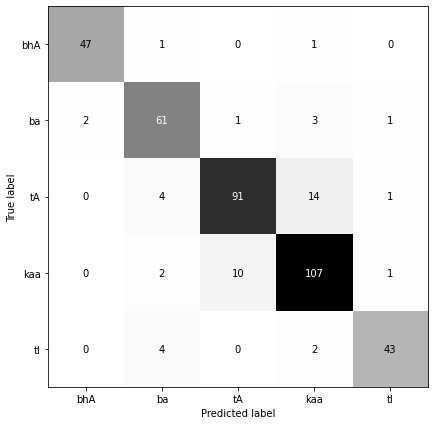

In [24]:
best_arch = 3
model = tf.keras.models.load_model(f'models/Q2/lstm/arch_{best_arch}.tf')
pred = np.argmax(model.predict(test_tensor), axis=1)

fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111)
cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(pred, np.argmax(z_test_onehot, axis=1)), display_labels=chars)
cm_display.plot(ax = ax, cmap='Greys', colorbar=False)
plt.show()